# **8.The Baseline Modelling**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import email
import seaborn as sns
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [35]:
import joblib
df = joblib.load('/content/drive/MyDrive/case study 2/final_40k.pkl')

In [36]:
df.shape

(41474, 2)

In [38]:
df.head()

,mail,len
0,here our forecast,17
1,traveling have business meeting takes the fun ...,534
2,test successful way,19
3,randy can you send schedule the salary and lev...,132
4,let shoot for tuesday,21


In [39]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(df.mail, test_size=0.30, random_state=42)

In [40]:
x = []
y = []
for i in tqdm(train):
  a = i.split()
  for j in range(1,len(a)):
        x.append(' '.join(a[:j]))
        y.append(' '.join(a[j:]))

100%|██████████| 29031/29031 [00:01<00:00, 22693.37it/s]


In [41]:
train_set = pd.DataFrame(data={'x_train':x,'y_train':y})
train_set['x_train'] = '<start> ' + train_set['x_train'] + ' <end>'
train_set['y_train'] = '<start> ' + train_set['y_train'] + ' <end>'
train_set.head()

,x_train,y_train
0,<start> can <end>,<start> everyone meet today please let know da...
1,<start> can everyone <end>,<start> meet today please let know daren <end>
2,<start> can everyone meet <end>,<start> today please let know daren <end>
3,<start> can everyone meet today <end>,<start> please let know daren <end>
4,<start> can everyone meet today please <end>,<start> let know daren <end>


In [48]:
train_set['x_train_len'] = train_set['x_train'].apply(lambda text:len(text.split()))

#here we remove all the rows from x_train / x_test where len is less then 10 and more then 20
train_set = train_set[train_set['x_train_len']>10]
train_set = train_set[train_set['x_train_len']<20]

In [42]:
x_test = []
y_test = []
for i in tqdm(test):
  a = i.split()
  for j in range(1,len(a)):
        x_test.append(' '.join(a[:j]))
        y_test.append(' '.join(a[j:]))

100%|██████████| 12443/12443 [00:00<00:00, 18345.84it/s]


In [43]:
test_set = pd.DataFrame(data={'x_test':x_test,'y_test':y_test})
test_set['x_test'] = '<start> ' + test_set['x_test'] + ' <end>'
test_set['y_test'] = '<start> ' + test_set['y_test'] + ' <end>'
test_set.head()

,x_test,y_test
0,<start> derek <end>,<start> can you forward the <end>
1,<start> derek can <end>,<start> you forward the <end>
2,<start> derek can you <end>,<start> forward the <end>
3,<start> derek can you forward <end>,<start> the <end>
4,<start> begin <end>,<start> get the actual presentations set anyon...


In [71]:
test_set['x_test_len'] = test_set['x_test'].apply(lambda text:len(text.split()))

#here we remove all the rows from x_train / x_test where len is less then 10 and more then 20
test_set = test_set[test_set['x_test_len']>10]
test_set = test_set[test_set['x_test_len']<20]
test_set.shape

(64032, 3)

In [72]:
tk = Tokenizer()#filters: If not provided, by default filters out all punctuation terms
tk_text = tk.fit_on_texts(list(train_set.x_train))
vocab = len(tk.word_index) + 1
print('the vocab size is', vocab)

the vocab size is 8785


In [73]:
#now we convert train and text datainto a corresponding index
train_seq = tk.texts_to_sequences(list(train_set.x_train))
print('the length of the train seq' ,len(train_seq[0]))
#took padding length as 9000 because in each data points has avg 30 words sentence.
train_data = pad_sequences(train_seq ,padding="post", maxlen=30)

test_seq = tk.texts_to_sequences(list(test_set.x_test))
print('the length of test seq',len(test_seq[0]))
test_data = pad_sequences(test_seq, padding="post",maxlen=30)

the length of the train seq 11
the length of test seq 11


In [74]:
tk_y = Tokenizer()#filters: If not provided, by default filters out all punctuation terms
tk_text_y = tk_y.fit_on_texts(list(train_set.y_train))
vocab_y = len(tk_y.word_index) + 1
print('the vocab size is', vocab_y)

the vocab size is 9549


In [75]:
#now we convert train and text datainto a corresponding index
train_seq_y = tk_y.texts_to_sequences(list(train_set.y_train))
print('the length of the train seq' ,len(train_seq_y[0]))
#took padding length as 9000 because in each data points has avg 30 words sentence.
train_data_y = pad_sequences(train_seq_y ,padding="post", maxlen=30)

test_seq_y = tk_y.texts_to_sequences(list(test_set.y_test))
print('the length of test seq',len(test_seq_y[0]))
test_data_y = pad_sequences(test_seq_y, padding="post",maxlen=30)

the length of the train seq 3
the length of test seq 38


In [77]:
#the very very basic LSTM model with the some hidden layes
tf.keras.backend.clear_session()
input_lay = tf.keras.Input(shape=(30,))

emd_layer = tf.keras.layers.Embedding(vocab, 300, input_length=30)(input_lay)
dense1 = tf.keras.layers.LSTM(300,return_sequences=True)(emd_layer)

dropout_lay1 = tf.keras.layers.Dropout(rate = 0.3 , name = 'dropout_lay1')(dense1)

dense2 = tf.keras.layers.Dense(512,activation='relu', kernel_initializer=tf.keras.initializers.he_normal, name = 'dense2')(dropout_lay1)

dropout_lay2 = tf.keras.layers.Dropout(rate = 0.3 , name = 'dropout_lay2')(dense2)

dense3 = tf.keras.layers.Dense(512,activation='relu', kernel_initializer=tf.keras.initializers.he_normal ,name = 'dense3')(dropout_lay2)

output = tf.keras.layers.Dense(vocab_y,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal , name = 'output')(dense3)

model = tf.keras.Model(inputs= input_lay, outputs=output)

In [78]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           2635500   
                                                                 
 lstm (LSTM)                 (None, 30, 300)           721200    
                                                                 
 dropout_lay1 (Dropout)      (None, 30, 300)           0         
                                                                 
 dense2 (Dense)              (None, 30, 512)           154112    
                                                                 
 dropout_lay2 (Dropout)      (None, 30, 512)           0         
                                                                 
 dense3 (Dense)              (None, 30, 512)           262656

In [79]:
optimizer=tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [80]:
his = model.fit(train_data, train_data_y, epochs=10, validation_data=(test_data,test_data_y) , batch_size=512)

Epoch 1/10
295/295 [==============================] - 78s 257ms/step - loss: 4.4287 - accuracy: 0.4287 - val_loss: 4.2585 - val_accuracy: 0.4386
Epoch 2/10
295/295 [==============================] - 75s 254ms/step - loss: 4.0479 - accuracy: 0.4372 - val_loss: 4.3853 - val_accuracy: 0.4335
Epoch 3/10
295/295 [==============================] - 75s 253ms/step - loss: 3.8762 - accuracy: 0.4414 - val_loss: 4.5974 - val_accuracy: 0.4108
Epoch 4/10
295/295 [==============================] - 75s 254ms/step - loss: 3.7059 - accuracy: 0.4478 - val_loss: 4.9647 - val_accuracy: 0.4038
Epoch 5/10
295/295 [==============================] - 75s 254ms/step - loss: 3.5424 - accuracy: 0.4542 - val_loss: 5.3767 - val_accuracy: 0.3863
Epoch 6/10
295/295 [==============================] - 75s 254ms/step - loss: 3.3925 - accuracy: 0.4603 - val_loss: 5.5857 - val_accuracy: 0.3733
Epoch 7/10
295/295 [==============================] - 75s 253ms/step - loss: 3.2563 - accuracy: 0.4658 - val_loss: 5.7213 - val_ac

In [81]:
h = his.history
loss = h['loss']
val_loss = h['val_loss']

Text(0.5, 1.0, 'Loss Vs No of epochs')

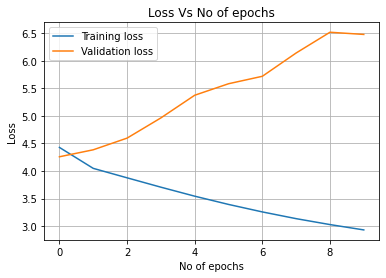

In [82]:
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')

Text(0.5, 1.0, 'accuracy Vs No of epochs')

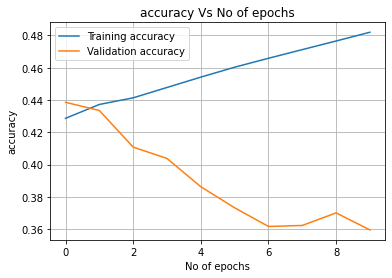

In [83]:
accuracy = h['accuracy']
val_accuracy = h['val_accuracy']
plt.plot(accuracy,label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('accuracy')
plt.title('accuracy Vs No of epochs')

In [101]:
eng_word = tk_y.word_index
new_dict = dict([(value, key) for key, value in eng_word.items()])

In [102]:
import numpy as np
def predict(train):
  a = model.predict(train.reshape(-1,30))
  f = []
  d = []
  for i in a[0]:
    #print(i)
    f.append(np.argmax(i))
  for  i in f:
    if i != 0:
      d.append(new_dict[i])

  return(' '.join(d))

In [103]:
predict(train_data[185])

'start responded normally the the the enron attorney attorney mexico internal internal internal internal signed appointed appointed appointed tax into into this this this add your your thanks regards end'

In [104]:
data_sam = train_set.sample(15000)
import nltk.translate.bleu_score as bleu
bleu_score = []
for i in tqdm(range(15000)):
  actual  = data_sam.y_train.values[i]
  input = tk.texts_to_sequences([str(data_sam.x_train.values[i])])
  input = pad_sequences(input, padding="post",maxlen= 30)
  Predict = predict(input)
  bleu_score.append(bleu.sentence_bleu([actual.split(),], Predict.split()))
print()
print('Bleu Score ==> ', np.mean(bleu_score))

  0%|          | 0/15000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 3/15000 [00:00<10:58, 22.79it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 9/15000 [00:00<11:28, 21.77it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 15000/15000 [11:30<00:00, 21.73it/s]


Bleu Score ==>  0.2063198597853522


**The Bleu score is 0.20 and improves the bleu score we use the encoder and decoder-based model.**

# 9 **Encoder Decoder Model**

In [5]:
import joblib
df = joblib.load('clean.pkl')

In [6]:
#df = df.sample(15000)
df.head()

,clean
0,here is our forecast
1,traveling to have a business meeting takes the...
2,plus your thoughts on any changes that need to...
3,follow these steps so you do not misplace thes...
4,i have been involved in most of the meetings a...


In [7]:
x = []
y = []
for i in tqdm(df.clean):
  a = i.split()
  for j in range(1,len(a)):
        x.append(' '.join(a[:j]))
        y.append(' '.join(a[j:]))

100%|██████████| 79616/79616 [00:07<00:00, 10560.59it/s]


In [8]:
train_set = pd.DataFrame(data={'x_train':x,'y_train':y})
# train_set['x_train'] = '<start> ' + train_set['x_train'] + ' <end>'
# train_set['y_train'] = '<start> ' + train_set['y_train'] + ' <end>'
train_set.head()

,x_train,y_train
0,here,is our forecast
1,here is,our forecast
2,here is our,forecast
3,traveling,to have a business meeting takes the fun out o...
4,traveling to,have a business meeting takes the fun out of t...


In [9]:
train_set.shape

(2180436, 2)

In [10]:
train_set['x_train_len'] = train_set['x_train'].apply(lambda text:len(text.split()))
train_set['y_train_len'] = train_set['y_train'].apply(lambda text:len(text.split()))

In [11]:
train_set.head()

,x_train,y_train,x_train_len,y_train_len
0,here,is our forecast,1,3
1,here is,our forecast,2,2
2,here is our,forecast,3,1
3,traveling,to have a business meeting takes the fun out o...,1,101
4,traveling to,have a business meeting takes the fun out of t...,2,100


In [13]:
#here we remove all the rows from data where len is less then 3 and greater than 30
train_set = train_set[train_set['x_train_len']>3]
train_set = train_set[train_set['x_train_len']<30]
train_set = train_set[train_set['y_train_len']<8]
train_set.shape

(344472, 4)

In [14]:
max(train_set.x_train_len.values)

29

In [15]:
max(train_set.y_train_len.values)

7

In [16]:
data = train_set

In [17]:
data['enc_inp'] = '<start> ' + data['x_train'].astype(str)  + ' <end>'
data['dec_inp'] = '<start> ' + data['y_train'].astype(str)
data['our'] = data['y_train'].astype(str) + ' <end>'
data = data.drop(['x_train','y_train','x_train_len', 'y_train_len'], axis=1)
data.head()

,enc_inp,dec_inp,our
107,<start> plus your thoughts on <end>,<start> any changes that need to be made,any changes that need to be made <end>
108,<start> plus your thoughts on any <end>,<start> changes that need to be made,changes that need to be made <end>
109,<start> plus your thoughts on any changes <end>,<start> that need to be made,that need to be made <end>
110,<start> plus your thoughts on any changes that...,<start> need to be made,need to be made <end>
111,<start> plus your thoughts on any changes that...,<start> to be made,to be made <end>


In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.33)

In [19]:
print('The shape of the train data ==>', train.shape)
print('The shape of the test  data ==>', test.shape)

The shape of the train data ==> (230796, 3)
The shape of the test  data ==> (113676, 3)


In [20]:
#Train dataset
x_train_encoder = train.enc_inp.values
x_train_decoder = train.dec_inp.values
y_train         = train.our.values

In [21]:
#test dataset
x_test_encoder = test.enc_inp.values
x_test_decoder = test.dec_inp.values
y_test         = test.our.values

In [22]:
print('y_train shape and y_test shape ==>' , y_train.shape, y_test.shape)

y_train shape and y_test shape ==> (230796,) (113676,)


In [23]:
def padding(train , test):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
  tokenizer.fit_on_texts(train)

  x_train =  tokenizer.texts_to_sequences(train)
  x_test  =  tokenizer.texts_to_sequences(test)


  # padding train and test data using the maximum length
  x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post')
  x_test  = tf.keras.preprocessing.sequence.pad_sequences(x_test,  padding='post')

  return tokenizer , x_train , x_test

In [24]:
enc_token , x_train_enc , x_test_enc = padding(x_train_encoder , x_test_encoder)
dec_token , x_train_dec , x_test_dec = padding(x_train_decoder , x_test_decoder)
y_token   , y_train     , y_test     = padding(y_train , y_test)

In [25]:
input_vocab  = len(enc_token.word_index) + 1
output_vocab = len(y_token.word_index) + 1
print('input vocab size ==>' , input_vocab)
print('output vocab size ==>' , output_vocab)

input vocab size ==> 18565
output vocab size ==> 12075


In [26]:
print('Encoder input length ==>' , x_train_enc.shape[1])
print('Decoder input length ==>' , x_train_dec.shape[1])

Encoder input length ==> 31
Decoder input length ==> 8


In [27]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size= lstm_size
        self.embedding = tf.keras.layers.Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size, name="embedding_layer_encoder")
        self.lstm = tf.keras.layers.LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM", recurrent_initializer='glorot_uniform')

    def call(self,input_sequence,initial_state):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      input_embedd = self.embedding(input_sequence)
      lstm_output, lstm_state_h, lstm_state_c = self.lstm(input_embedd,initial_state = initial_state)
      return lstm_output, lstm_state_h, lstm_state_c
    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state shape is [32,lstm_units], cell state shape is [32,lstm_units]
      '''
      return tf.zeros((batch_size, self.lstm_size)) , tf.zeros((batch_size, self.lstm_size))

In [28]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_size = embedding_size
      self.input_length = input_length
      self.lstm_size= lstm_size

        #Initialize Embedding layer
        #Intialize Decoder LSTM layer

      self.embedding = tf.keras.layers.Embedding(input_dim = self.out_vocab_size, output_dim = self.embedding_size, name="embedding_decoder_layer")
      
      self.lstm = tf.keras.layers.LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Decoder_lstm_layer", recurrent_initializer='glorot_uniform')
        


    def call(self,input_sequence,initial_states):


      
      input_embedd = self.embedding(input_sequence)
      decoder_output, decoder_final_state_h, decoder_final_state_c = self.lstm(input_embedd,initial_state = initial_states)
      return decoder_output, decoder_final_state_h, decoder_final_state_c

In [29]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,encoder_inputs_length,decoder_inputs_length, output_vocab_size):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        #(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        self.encoder = Encoder(inp_vocab_size = input_vocab, embedding_size =  256, lstm_size = 200, input_length= encoder_inputs_length)
        self.decoder = Decoder(out_vocab_size = output_vocab, embedding_size = 256, lstm_size = 200, input_length= decoder_inputs_length)
        self.dense   = Dense(output_vocab_size, activation='softmax')
        
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
    
    
    def call(self,data):

        input_to_encoder,input_to_decoder = data[0], data[1]
        initial_state= self.encoder.initialize_states(tf.shape(input_to_encoder)[0])
        encoder_output,state_h,state_c = self.encoder(input_to_encoder,initial_state)

        decoder_output, decoder_final_state_h, decoder_final_state_c = self.decoder(input_to_decoder, [state_h,state_c]) 
        decoder_output = self.dense(decoder_output)

        # return the decoder output
        return decoder_output

In [30]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation , add
model  = Encoder_decoder(encoder_inputs_length=31 ,decoder_inputs_length=8 , output_vocab_size = output_vocab)


# loss_object = loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()
#defining callbacks
his = tf.keras.callbacks.History()
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs/model2') , his]
#compiling the model

model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')

model.fit([x_train_enc , x_train_dec], y_train, batch_size=512,epochs = 20, validation_data = ([x_test_enc,x_test_dec], y_test) , callbacks = callbacks)

Epoch 1/20
451/451 [==============================] - 73s 140ms/step - loss: 3.5190 - val_loss: 3.0149
Epoch 2/20
451/451 [==============================] - 61s 136ms/step - loss: 2.8891 - val_loss: 2.7659
Epoch 3/20
451/451 [==============================] - 63s 139ms/step - loss: 2.6982 - val_loss: 2.6425
Epoch 4/20
451/451 [==============================] - 62s 139ms/step - loss: 2.5744 - val_loss: 2.5247
Epoch 5/20
451/451 [==============================] - 63s 139ms/step - loss: 2.4563 - val_loss: 2.4212
Epoch 6/20
451/451 [==============================] - 62s 139ms/step - loss: 2.3152 - val_loss: 2.2715
Epoch 7/20
451/451 [==============================] - 63s 139ms/step - loss: 2.1634 - val_loss: 2.1566
Epoch 8/20
451/451 [==============================] - 63s 139ms/step - loss: 2.0493 - val_loss: 2.0784
Epoch 9/20
451/451 [==============================] - 63s 139ms/step - loss: 1.9576 - val_loss: 2.0160
Epoch 10/20
451/451 [==============================] - 63s 139ms/step - l

In [31]:
joblib.dump(his.history,'history1')

['history1']

In [32]:
#Save weights
model.save_weights('best_model1.h5')

In [33]:
#Load weights
model.load_weights('best_model1.h5')

In [34]:
his2 = tf.keras.callbacks.History()
callbacks = [his2]
model.fit([x_train_enc , x_train_dec], y_train, batch_size=512,epochs = 20, validation_data = ([x_test_enc,x_test_dec], y_test) , callbacks = callbacks)

Epoch 1/20
451/451 [==============================] - 62s 137ms/step - loss: 1.3110 - val_loss: 1.6380
Epoch 2/20
451/451 [==============================] - 61s 136ms/step - loss: 1.2743 - val_loss: 1.6220
Epoch 3/20
451/451 [==============================] - 61s 136ms/step - loss: 1.2394 - val_loss: 1.6093
Epoch 4/20
451/451 [==============================] - 61s 136ms/step - loss: 1.2059 - val_loss: 1.5961
Epoch 5/20
451/451 [==============================] - 62s 139ms/step - loss: 1.1738 - val_loss: 1.5847
Epoch 6/20
451/451 [==============================] - 61s 136ms/step - loss: 1.1430 - val_loss: 1.5732
Epoch 7/20
451/451 [==============================] - 61s 136ms/step - loss: 1.1132 - val_loss: 1.5648
Epoch 8/20
451/451 [==============================] - 61s 136ms/step - loss: 1.0849 - val_loss: 1.5542
Epoch 9/20
451/451 [==============================] - 61s 136ms/step - loss: 1.0577 - val_loss: 1.5480
Epoch 10/20
451/451 [==============================] - 61s 136ms/step - l

In [35]:
joblib.dump(his2.history,'history2')

['history2']

In [36]:
h1 = joblib.load('history1')
h2 = joblib.load('history2')
loss = h1['loss']+h2['loss']
val_loss = h1['val_loss']+h2['val_loss']

Text(0.5, 1.0, 'Loss Vs No of epochs')

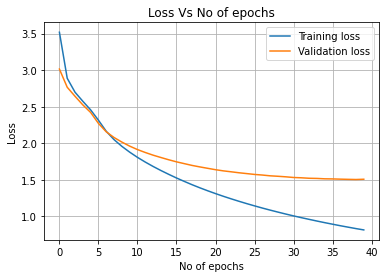

In [37]:
# loss = his.history['loss']
# val_loss = his.history['val_loss']
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')

In [38]:
model.save_weights('/content/drive/MyDrive/model1/best_model1.h5')

In [44]:
#here we change the key value pair to value key pair
eng_word = y_token.word_index
new_dict = dict([(value, key) for key, value in eng_word.items()])
new_dict[0] = 'start'

In [45]:
#joblib.dump(new_dict , 'new_dict.pkl')

In [51]:
def predict(input_sentence):
# A. Given input sentence, convert the sentence into integers using tokenizer used earlier
#here we also check the we have the start and end token in sentences
#then we convert out input into to token and do a padding
  input = input_sentence
  if input.split(' ')[0] != '<start>' and input.split(' ')[-1] != '<end>':
    input = '<start>'+ ' ' + input + ' ' + '<end>'
  else:
    input = str(input)
  input = enc_token.texts_to_sequences([str(input)])
  input = pad_sequences(input, padding="post",maxlen= 31)

#as we know we have a three layer 1 ==> encoder 2 ==> decoder 3 ==> dense
#so first is encoder we give the input as input sec and ini_state

  enc_ini_states = model.layers[0].initialize_states(1)
  enc_out, enc_h_state, enc_c_state = model.layers[0](input, enc_ini_states)

#output of the encoder is a input as decoder
# first word input of decoder is start token 
# then 2nd input of decoder is predecting word by model

  decoder_initial_state = [enc_h_state, enc_c_state]
  decoder_initial_input = np.zeros((1,1))
  decoder_initial_input[0,0] = dec_token.word_index['<start>']

  predict_word = []
  w = []
  for i in range(31):
    dec_out, dec_h_state, dec_c_state = model.layers[1](decoder_initial_input, decoder_initial_state)
    # we use 3rd layer and we get the max proba word as out put and the this word is next input of the decoder 
    english_predict = np.argmax(model.layers[2](dec_out).numpy().ravel())
    predict_word.append(english_predict)
    decoder_initial_input[0,0] = english_predict
    #replacing the next decoder initial states with current decoder output 
    decoder_initial_state = [dec_h_state, dec_c_state]
    w.append(new_dict[english_predict])

    if new_dict[english_predict] == '<end>':
      break
  return ' '.join(w)

In [52]:
predict('<start> you have any <end>')

'question about the attached <end>'

In [53]:
predict('<start> here is our <end>')

'latest contact list <end>'

In [55]:
predict('<start> how are you and hope <end>')

'you have a great weekend <end>'

In [56]:
data_sam = data.sample(20)
for i in range(20):
  print('Input  ==>' , data_sam.enc_inp.values[i])
  print('Output ==>' , data_sam.dec_inp.values[i])
  print('Predict ==>', predict(data_sam.enc_inp.values[i]))
  print(50 * '==')

Input  ==> <start> we would like to accommodate your group if possible that <end>
Output ==> <start> is fantastic
Predict ==> would be great <end>
Input  ==> <start> if you have any questions please do <end>
Output ==> <start> not hesitate to call me
Predict ==> not hesitate to contact me <end>
Input  ==> <start> this is the procedure he has set for me i do not mean to complicate your life further but would really appreciate <end>
Output ==> <start> it if you could do this
Predict ==> it if you can <end>
Input  ==> <start> when asked whether as auditor for the railroad he would does this sound like the right <end>
Output ==> <start> case
Predict ==> one <end>
Input  ==> <start> there is a little controversy over this issue because the incentive is not offered to small business <end>
Output ==> <start> or residents
Predict ==> of their respective positions <end>
Input  ==> <start> what a great season hope you have a <end>
Output ==> <start> good thanksgiving
Predict ==> good job <end>
I

### 9.1 BLUE score after the 20 epochs

In [ ]:
from tqdm import tqdm
data_sam = data.sample(10000)
import nltk.translate.bleu_score as bleu
bleu_score = []
for i in tqdm(range(1000)):
  actual  = data.our.iloc[i] 
  Predict = predict(data.enc_inp.iloc[i])
  bleu_score.append(bleu.sentence_bleu([actual.split(),], Predict.split()))
print('Bleu Score ==> ', np.mean(bleu_score))

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 2/1000 [00:00<01:20, 12.39it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 4/1000 [00:00<01:20, 12.44it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 1000/1000 [00:46<00:00, 21.34it/s]

Bleu Score ==>  0.6419517045194466


### 9.2 BLUE score after the 40 epochs

In [60]:
from tqdm import tqdm
data_sam = data.sample(1000)
import nltk.translate.bleu_score as bleu
bleu_score = []
for i in tqdm(range(1000)):
  actual  = data_sam.our.iloc[i] 
  Predict = predict(data_sam.enc_inp.iloc[i])
  bleu_score.append(bleu.sentence_bleu([actual.split(),], Predict.split()))
print('Bleu Score ==> ', np.mean(bleu_score))

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 2/1000 [00:00<01:43,  9.69it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  2%|▏         | 22/1000 [00:01<01:10, 13.91it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 1000/1000 [00:44<00:00, 22.52it/s]

Bleu Score ==>  0.6823627720876825


In [ ]:
#Save weights
model.save_weights('final_model1.h5')

# 10 Encoder Decoder Model with Attention

In [2]:
import joblib
df = joblib.load('clean.pkl')

In [3]:
df = df.head(15000)
df.head()

,clean
0,here is our forecast
1,traveling to have a business meeting takes the...
2,plus your thoughts on any changes that need to...
3,follow these steps so you do not misplace thes...
4,i have been involved in most of the meetings a...


In [5]:
x = []
y = []
for i in tqdm(df.clean):
  a = i.split()
  for j in range(1,len(a)):
        x.append(' '.join(a[:j]))
        y.append(' '.join(a[j:]))

100%|██████████| 15000/15000 [00:02<00:00, 5893.47it/s]


In [6]:
train_set = pd.DataFrame(data={'x_train':x,'y_train':y})
train_set.head()

,x_train,y_train
0,here,is our forecast
1,here is,our forecast
2,here is our,forecast
3,traveling,to have a business meeting takes the fun out o...
4,traveling to,have a business meeting takes the fun out of t...


In [7]:
train_set['x_train_len'] = train_set['x_train'].apply(lambda text:len(text.split()))
train_set['y_train_len'] = train_set['y_train'].apply(lambda text:len(text.split()))

In [8]:
train_set = train_set[train_set['x_train_len']>3]
train_set = train_set[train_set['x_train_len']<30]
train_set = train_set[train_set['y_train_len']<8]
train_set.shape

(62250, 4)

In [9]:
data = train_set

In [10]:
data['enc_inp'] = '<start> ' + data['x_train'].astype(str)  + ' <end>'
data['dec_inp'] = '<start> ' + data['y_train'].astype(str)
data['our'] = data['y_train'].astype(str) + ' <end>'
data = data.drop(['x_train','y_train','x_train_len', 'y_train_len'], axis=1)
data.head()

,enc_inp,dec_inp,our
107,<start> plus your thoughts on <end>,<start> any changes that need to be made,any changes that need to be made <end>
108,<start> plus your thoughts on any <end>,<start> changes that need to be made,changes that need to be made <end>
109,<start> plus your thoughts on any changes <end>,<start> that need to be made,that need to be made <end>
110,<start> plus your thoughts on any changes that...,<start> need to be made,need to be made <end>
111,<start> plus your thoughts on any changes that...,<start> to be made,to be made <end>


In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.33)

In [12]:
#Train dataset
x_train_encoder = train.enc_inp.values
x_train_decoder = train.dec_inp.values
y_train         = train.our.values

In [13]:
#test dataset
x_test_encoder = test.enc_inp.values
x_test_decoder = test.dec_inp.values
y_test         = test.our.values

In [14]:
def padding(train , test):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
  tokenizer.fit_on_texts(train)

  x_train =  tokenizer.texts_to_sequences(train)
  x_test  =  tokenizer.texts_to_sequences(test)


  # padding train and test data using the maximum length
  x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post')
  x_test  = tf.keras.preprocessing.sequence.pad_sequences(x_test,  padding='post')

  return tokenizer , x_train , x_test

In [15]:
enc_token , x_train_enc , x_test_enc = padding(x_train_encoder , x_test_encoder)
dec_token , x_train_dec , x_test_dec = padding(x_train_decoder , x_test_decoder)
y_token   , y_train     , y_test     = padding(y_train , y_test)

In [16]:
input_vocab  = len(enc_token.word_index) + 1
output_vocab = len(y_token.word_index) + 1
print('input vocab size ==>' , input_vocab)
print('output vocab size ==>' , output_vocab)

input vocab size ==> 8555
output vocab size ==> 5544


In [17]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
      self.input_vocab = inp_vocab_size
      self.embd_size   = embedding_size
      self.lstm_size   = lstm_size
      self.input_length = input_length

      self.embadding = Embedding(input_dim = self.input_vocab, output_dim = self.embd_size, name="embedding_layer_encoder")
      self.lstm      = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")


        #Initialize Embedding layer
        #Intialize Encoder LSTM layer

    def call(self,input_sequence,states):

      input_embd = self.embadding(input_sequence)
      lstm_output, lstm_state_h, lstm_state_c = self.lstm(input_embd , states)
      return lstm_output, lstm_state_h, lstm_state_c

    
    def initialize_states(self,batch_size):

      return tf.zeros((batch_size, self.lstm_size)) , tf.zeros((batch_size, self.lstm_size))
      

In [18]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function = scoring_function

    if self.scoring_function=='dot':
      self.mul = tf.matmul
      pass
    if scoring_function == 'general':
      self.dense = Dense(att_units)
      self.mul   = tf.matmul
      pass
    elif scoring_function == 'concat':
      self.tanh_activation = tf.nn.tanh
      self.dense_concat_1  = Dense(att_units)
      self.dense_concat_2  = Dense(att_units)
      self.dens_1          = Dense(1)
      pass

  def call(self,decoder_hidden_state,encoder_output):

    if self.scoring_function == 'dot':
      decoder_hidden_state = tf.expand_dims(decoder_hidden_state, -1)
      score = self.mul(encoder_output , decoder_hidden_state)
      pass

    elif self.scoring_function == 'general':
      transformed_enc_out  = self.dense(encoder_output)
      decoder_hidden_state = tf.expand_dims(decoder_hidden_state, -1)
      score = self.mul(transformed_enc_out, decoder_hidden_state)
      pass

    elif self.scoring_function == 'concat':
      transform_enc_out = self.dense_concat_1(encoder_output)
      transform_dec_hidden_state = self.dense_concat_2(decoder_hidden_state)

      adding = add([transform_enc_out, tf.expand_dims(transform_dec_hidden_state,1)])
      adding = self.tanh_activation(adding)
      score = self.dens_1(adding)
      pass

    score = tf.squeeze(score, axis = -1)
    attention_weight = tf.nn.softmax(score)

    attention_weight = tf.expand_dims(attention_weight, axis = -1)
    #print(attention_weight.shape)
    context_vector = tf.matmul(tf.transpose(encoder_output, perm = [0,2,1]), attention_weight)
    context_vector = tf.squeeze(context_vector, axis = -1)
    return context_vector, attention_weight

In [19]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

    super().__init__()
    self.tar_vocab_size = tar_vocab_size
    self.embedding_dim  = embedding_dim
    self.input_length  = input_length
    self.dec_units      = dec_units
    self.score_fun      = score_fun
    self.att_units      = att_units

    #defining the lstm, embedding dense and Attention layer

    self.embadding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, name= 'embedding_layer_decoder')
    self.lstm      = LSTM(self.dec_units, return_state=True,return_sequences=True, name='lstm_layer_decoder')
    self.dense     = Dense(self.tar_vocab_size, name= 'dense_layer_decoder')
    self.attention = Attention(self.score_fun, self.att_units)


      # Initialize decoder embedding layer, LSTM and any other objects needed



  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''

    input = self.embadding(input_to_decoder)
    context_vector, attention_weights = self.attention(state_h , encoder_output)
    concat = tf.concat([tf.expand_dims(context_vector, 1), input], axis=-1)

    decoder_output, state_h, state_c = self.lstm(concat)
    decoder_output = tf.reshape(decoder_output, (-1, decoder_output.shape[2]))
    output = self.dense(decoder_output)

    return output, state_h, state_c, attention_weights, context_vector


In [20]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()

      self.out_vocab_size = out_vocab_size
      self.embedding_dim  = embedding_dim
      self.input_length   = input_length
      self.dec_units      = dec_units
      self.score_fun      = score_fun
      self.att_units      = att_units
      self.One_Step_Decoder = One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units, self.score_fun, self.att_units)

        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        final_outputs= tf.TensorArray(tf.float32, size= input_to_decoder.shape[1], name="output_arrays")
        #Create a tensor array as shown in the reference notebook
        #Iterate till the length of the decoder input
        for timestep in range(input_to_decoder.shape[1]):
          # Call onestepdecoder for each token in decoder_input
          output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.One_Step_Decoder(input_to_decoder[:,timestep:timestep+1], encoder_output, decoder_hidden_state,decoder_cell_state )
          final_outputs = final_outputs.write(timestep, output)
        
        # Store the output in tensorarray
        final_outputs = tf.transpose(final_outputs.stack(), [1, 0, 2])
        # Return the tensor array
        return final_outputs
            
        
    

In [21]:
class encoder_decoder(tf.keras.Model):
  def __init__(self, inp_vocab_size, out_vocab_size, embedding_size, enc_lstm_units, dec_lstm_units, enc_input_length, dec_input_length, score_fun, att_units):
    super().__init__()
    self.inp_vocab_size = inp_vocab_size
    self.out_vocab_size = out_vocab_size
    self.embedding_size = embedding_size
    self.enc_lstm_units = enc_lstm_units
    self.dec_lstm_units = dec_lstm_units
    self.enc_input_length = enc_input_length
    self.dec_input_length = dec_input_length
    self.score_fun = score_fun
    self.att_units = att_units
    #Intialize objects from encoder decoder
    
    self.encoder = Encoder(self.inp_vocab_size, self.embedding_size, self.enc_lstm_units, self.enc_input_length)
    self.decoder = Decoder(self.out_vocab_size, self.embedding_size, self.dec_input_length, self.dec_lstm_units, self.score_fun, self.att_units)
    #there is no need to dense layer because we use a custom loss funn..
    #self.dense   = Dense(self.out_vocab_size, activation='softmax')

  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    encoder_input , decoder_input = data[0] , data[1]
    enc_initial_state= self.encoder.initialize_states(tf.shape(encoder_input)[0])
    enc_out, enc_h_state, enc_c_state = self.encoder(encoder_input, enc_initial_state)

    dec_out = self.decoder(decoder_input, enc_out, enc_h_state, enc_c_state)
    #dec_out = self.dense(dec_out)
    return dec_out

In [39]:
#defining the model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation , add
#self, inp_vocab_size, out_vocab_size, embedding_size, enc_lstm_units, dec_lstm_units, enc_input_length, dec_input_length, score_fun, att_units
tf.keras.backend.clear_session()
attention_dot_model = encoder_decoder(inp_vocab_size = input_vocab, out_vocab_size = output_vocab,
                                      embedding_size = 256, enc_lstm_units = 200, dec_lstm_units = 200, 
                                      enc_input_length = 31, dec_input_length = 8, score_fun = 'dot', 
                                      att_units = 200)
his = tf.keras.callbacks.History()
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs/model3') , his]
#compiling the model
attention_dot_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy')

In [40]:
attention_dot_model.fit([x_train_enc , x_train_dec], y_train, batch_size = 512, epochs = 20, validation_data = ([x_test_enc,x_test_dec], y_test), callbacks = callbacks)

Epoch 1/20
82/82 [==============================] - 36s 214ms/step - loss: 8.4089 - val_loss: 7.7504
Epoch 2/20
82/82 [==============================] - 13s 159ms/step - loss: 7.8038 - val_loss: 7.8336
Epoch 3/20
82/82 [==============================] - 14s 169ms/step - loss: 7.9021 - val_loss: 7.9404
Epoch 4/20
82/82 [==============================] - 14s 168ms/step - loss: 7.7836 - val_loss: 7.8219
Epoch 5/20
82/82 [==============================] - 13s 159ms/step - loss: 7.8078 - val_loss: 7.8682
Epoch 6/20
82/82 [==============================] - 14s 168ms/step - loss: 7.8405 - val_loss: 7.8865
Epoch 7/20
82/82 [==============================] - 13s 158ms/step - loss: 7.7629 - val_loss: 7.7553
Epoch 8/20
82/82 [==============================] - 14s 168ms/step - loss: 7.7562 - val_loss: 7.8049
Epoch 9/20
82/82 [==============================] - 14s 167ms/step - loss: 7.8071 - val_loss: 7.8610
Epoch 10/20
82/82 [==============================] - 14s 168ms/step - loss: 7.8822 - val_lo

In [35]:
eng_word = y_token.word_index
new_dict = dict([(value, key) for key, value in eng_word.items()])
new_dict[0] = 'start'

In [36]:
model = attention_dot_model
def predict_dot_model(input_sentence):
# A. Given input sentence, convert the sentence into integers using tokenizer used earlier
#here we also check the we have the start and end token in sentences
#then we convert out input into to token and do a padding
  input = input_sentence
  if input.split(' ')[0] != '<start>' and input.split(' ')[-1] != '<end>':
    input = '<start>'+ ' ' + input + ' ' + '<end>'
  else:
    input = str(input)
  input = enc_token.texts_to_sequences([str(input)])
  input = pad_sequences(input, padding= 'post',maxlen= 20)

#as we know we have a two layer 1 ==> encoder 2 ==> decoder
#so first is encoder we give the input as input sec and ini_state

  enc_ini_states = model.layers[0].initialize_states(1)
  enc_out, enc_h_state, enc_c_state = model.layers[0](input, enc_ini_states)

  dec_h_state = enc_h_state
  dec_c_state = enc_c_state


#output of the encoder is a input as decoder
# first word input of decoder is start token 
# then 2nd input of decoder is predecting word by model

  decoder_initial_input = np.zeros((1,1))
  decoder_initial_input[0,0] = dec_token.word_index['<start>']

#here we store the word weigth , word and predicted word here predicted word means word token and word means word token corresponding word
  predict_word = []
  word = []
  all_weight = []
  for i in range(20):

    predict , dec_h_state, dec_c_state, att_weight, con_vector =  model.layers[1].One_Step_Decoder(decoder_initial_input, enc_out, dec_h_state, dec_c_state)

    # we use 3rd layer and we get the max proba word as out put and the this word is next input of the decoder 
    english_predict = np.argmax((predict).numpy().ravel())
    predict_word.append(english_predict)
    decoder_initial_input[0,0] = english_predict
    #replacing the next decoder initial states with current decoder output 
    #decoder_initial_state = [dec_h_state, dec_c_state]
    word.append(new_dict[english_predict])
    all_weight.append(att_weight.numpy().ravel())

    weight = np.array(all_weight)

    if new_dict[english_predict] == '<end>':
      break 
  return ' '.join(word) , weight #return the weight and predicted word
predict_dot_model('<start> how are you and tell me  <end>')[0]

'matter <end>'

In [37]:
data_sam = data.sample(20)
for i in range(20):
  print('Input  ==>' , data_sam.enc_inp.iloc[i])
  print('Output ==>' , data_sam.our.iloc[i])
  print('Predict ==>', predict_dot_model(data_sam.enc_inp.iloc[i])[0])
  print(50 * '==')

Input  ==> <start> you got it please forward to others whom you think might <end>
Output ==> be interested <end>
Predict ==> matter <end>
Input  ==> <start> we will use the same <end>
Output ==> gas quality for each location <end>
Predict ==> matter <end>
Input  ==> <start> currently you can only request test access production access should be added later this <end>
Output ==> week <end>
Predict ==> matter <end>
Input  ==> <start> i hope that you will be <end>
Output ==> able to participate <end>
Predict ==> matter <end>
Input  ==> <start> can you reassure me you <end>
Output ==> are making up for my ineptitude <end>
Predict ==> matter <end>
Input  ==> <start> i approve the expense and hourly rate might be the bargain <end>
Output ==> of the century <end>
Predict ==> matter <end>
Input  ==> <start> i would request that these receivables get written off in order to clean up the books if you have any questions please do not <end>
Output ==> hesitate to give me a call <end>
Predict ==> se

In [33]:
data_sam = data.sample(1000)
import nltk.translate.bleu_score as bleu
bleu_score = []
for i in range(1000):
  reference  = data_sam.enc_inp.iloc[i] 
  translation = predict_dot_model(data_sam.enc_inp.iloc[i])[0]
  bleu_score.append(bleu.sentence_bleu([reference.split(),], translation.split()))
print('Bleu Score is ==> ', np.mean(bleu_score))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Bleu Score is ==>  0.22802166966108614


# Model Compering

In [3]:
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model Name", "BLUE Score"])

# Add rows
myTable.add_row(["Simple LSTM", "0.20"])
myTable.add_row(["Encoder Decoder" , '0.68'])
myTable.add_row(["Encoder Decoder With Attention", '0.22'])


print(myTable)

+--------------------------------+------------+
|           Model Name           | BLUE Score |
+--------------------------------+------------+
|          Simple LSTM           |    0.20    |
|        Encoder Decoder         |    0.68    |
| Encoder Decoder With Attention |    0.22    |
+--------------------------------+------------+
